<h1> Malaria </h1>

In [251]:
from __future__ import division
import numpy as np
import json
import re
import gzip
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import seaborn as sns
import datetime

from IPython.html.widgets import *
from nvd3 import pieChart
import nvd3
nvd3.ipynb.initialize_javascript(use_remote=True)

from ethiopian_date import ethiopian_date

pd.set_option('display.max_rows', 50)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'Text', 'interactive', 'Button', 'colors', 'Widget']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [913]:
def add_one_month(Date):
    if Date.month < 12:
        year = Date.year
        month = Date.month + 1
    else:
        year = Date.year + 1
        month = 1
    return pd.datetime(year, month, Date.day)

def sub_one_month(Date):
    if Date.month > 1:
        year = Date.year
        month = Date.month - 1
    else:
        year = Date.year - 1
        month = 12
    return pd.datetime(year, month, Date.day)

<h1> Load in the indicator names and make an indicator ID mapping </h1>

In [2]:
import sys
sys.path.append('/Users/attiladobi/zenysis')
import config.et.indicators

In [3]:
useful_groups = config.indicators.HMIS_GROUPS + [config.indicators.CALCULATED_INDICATOR_GROUP]

In [4]:
IDlookup = {val['id']:val for cluster in useful_groups for val in cluster['indicators']}
len(IDlookup)

1051

In [5]:
config.indicators.CALCULATED_INDICATOR_GROUP

{'groupId': 'zenysis-calculated-indicators',
 'groupText': 'Calculated Indicators',
 'groupTextShort': 'Calculated Indicators',
 'indicators': [{'decreaseIsGood': False,
   'id': 'hmis_c_1_1_1_1',
   'programAreas': ['Improve Access to Health Services',
    'Maternal and Child Health',
    'Maternal Health'],
   'text': 'Contraceptive acceptance rate'},
  {'decreaseIsGood': False,
   'id': 'hmis_c_1_1_1_2',
   'programAreas': ['Improve Access to Health Services',
    'Maternal and Child Health',
    'Maternal Health'],
   'text': 'Antenatal care coverage - First visit'},
  {'decreaseIsGood': False,
   'id': 'hmis_c_1_1_1_3',
   'programAreas': ['Improve Access to Health Services',
    'Maternal and Child Health',
    'Maternal Health'],
   'text': 'Antenatal care coverage - four visits'},
  {'decreaseIsGood': False,
   'id': 'hmis_c_1_1_1_4',
   'programAreas': ['Improve Access to Health Services',
    'Maternal and Child Health',
    'Maternal Health'],
   'text': 'Percentage of pregn

In [5]:
IDlookup['hmis_indicator_3633']

{'id': 'hmis_indicator_3633',
 'program_area': 'Communicable Diseases',
 'sub_area': 'HIV/AIDS',
 'text': 'Clients testing positive for HIV 25-49 years: Males'}

<h1> Load in population data </h1>

In [858]:
DF_pop = pd.read_excel('/Users/attiladobi/Documents/Ethiopia_pop.xlsx', header=2)
DF_pop.set_index('Map', inplace=True)
DF_pop.index = [name.lower() for name in DF_pop.index]
#convert population from string to int 
DF_pop['Population'] = [int(pop.replace(',','')) for pop in DF_pop['Population']]

In [859]:
DF_pop

,Name,Population,Area_km2,Density,Capital,Elevation_m,Climate
addis ababa,Addis Ababa (city),3273000,526.99,5198.49,Addis Ababa,2355,Cwb
afar,Afar Region,1723000,72052.8,19.58,Semera,614,BWh
amhara,Amhara Region,20401000,154709,111.28,Bahir Dar,1800,Aw
benishangul-gumuz,Benishangul-Gumuz Region,1005000,50698.7,13.23,Asosa,1570,Aw
dire dawa,Dire Dawa (city),440000,1558.61,219.32,Dire Dawa,1276,BSh
gambella,Gambela Region,409000,29782.8,10.31,Gambela,526,Aw
harreri,Harari Region,232000,333.94,549.03,Harar,1885,Cwb
oromiya,Oromia Region,33692000,284538,95.45,Addis Ababa,1700,Cwb
somali,Somali Region,5453000,279252,15.90,Jijiga,1609,Cwb
snnpr,"Southern Nations, Nationalities, and Peoples' ...",18276000,"105,476",142.06,Hawassa,1707,Aw


<h1> Add average temperature and precipitation data </h1>

In [862]:
DF_pop['ave_temp'] = [DF_weather['ANNUAL'][cap]['temp'] for cap in DF_pop['Capital']]
DF_pop['ave_prec_mm'] = [DF_weather['ANNUAL'][cap]['prec_mm'] for cap in DF_pop['Capital']]

In [863]:
DF_pop

,Name,Population,Area_km2,Density,Capital,Elevation_m,Climate,ave_temp,ave_prec_mm
addis ababa,Addis Ababa (city),3273000,526.99,5198.49,Addis Ababa,2355,Cwb,16.0,1210.0
afar,Afar Region,1723000,72052.8,19.58,Semera,614,BWh,28.4,11.5
amhara,Amhara Region,20401000,154709,111.28,Bahir Dar,1800,Aw,17.0,1430.0
benishangul-gumuz,Benishangul-Gumuz Region,1005000,50698.7,13.23,Asosa,1570,Aw,22.1,1281.8
dire dawa,Dire Dawa (city),440000,1558.61,219.32,Dire Dawa,1276,BSh,24.0,610.0
gambella,Gambela Region,409000,29782.8,10.31,Gambela,526,Aw,27.0,1204.9
harreri,Harari Region,232000,333.94,549.03,Harar,1885,Cwb,19.5,791.2
oromiya,Oromia Region,33692000,284538,95.45,Addis Ababa,1700,Cwb,16.0,1210.0
somali,Somali Region,5453000,279252,15.90,Jijiga,1609,Cwb,18.9,776.4
snnpr,"Southern Nations, Nationalities, and Peoples' ...",18276000,"105,476",142.06,Hawassa,1707,Aw,23.2,965.0


<h1> Load the data </h1>

In [914]:
with open('/Users/attiladobi/Downloads/malaria_2.json', 'rb') as f:
    data = f.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
DF2 = pd.read_json(data_json_str)

In [915]:
df_list = []
for region in DF2['byGeo'][0].keys():
    region_name = region.split('_')[0]
    meta_data = pd.DataFrame(DF2['byGeo'][0][region]['data']['month'])
    formatted_data = pd.DataFrame(meta_data[1:].stack()).reset_index(level=0)
    formatted_data.index = [pd.to_datetime(val) for val in formatted_data.index]
    formatted_data.columns = ['Indicator_id', 'val']
    formatted_data.index.name = 'Real_Date'
    formatted_data['Region'] = region_name
    df_list.append(formatted_data)
DF_ind=pd.concat(df_list)
DF_ind['Indicator'] = [IDlookup[val]['text'] for val in DF_ind['Indicator_id']]
#if '_c_' not in set(DF_ind['Indicator_id']):
#    DF_ind['program_area'] = [IDlookup[val]['program_area'] for val in DF_ind['Indicator_id']]
#    DF_ind['sub_area'] = [IDlookup[val]['sub_area'] for val in DF_ind['Indicator_id']]

In [916]:
DF_ind.groupby('Indicator').val.sum().reset_index()

,Indicator,val
0,Number of HHs that need LLINs in the last 12 m...,7.565760e+06
1,Number of slides or RDT positive for malaria,4.385023e+06
2,Number of slides or RDT positive for malaria 5...,4.577960e+05
3,Number of slides or RDT positive for malaria 5...,5.698000e+05
4,Number of slides or RDT positive for malaria <...,3.276930e+05
5,Number of slides or RDT positive for malaria <...,4.009010e+05
6,Number of slides or RDT positive for malaria >...,9.363940e+05
7,Number of slides or RDT positive for malaria >...,1.750456e+06
8,Number of targeted HHs received at least one L...,6.604124e+06
9,Proportion of targeted HH covered with LLIN in...,9.158958e+00


<h3> fix SNNPR data. Subtract two months </h3>

In [941]:
[sub_one_month(sub_one_month(date)) for date in DF_ind.loc[DF_ind['Region']=='snnpr'].index]

[datetime.datetime(2015, 6, 7, 0, 0),
 datetime.datetime(2016, 6, 7, 0, 0),
 datetime.datetime(2014, 4, 8, 0, 0),
 datetime.datetime(2014, 7, 11, 0, 0),
 datetime.datetime(2014, 8, 11, 0, 0),
 datetime.datetime(2014, 9, 10, 0, 0),
 datetime.datetime(2014, 10, 10, 0, 0),
 datetime.datetime(2014, 11, 9, 0, 0),
 datetime.datetime(2014, 12, 8, 0, 0),
 datetime.datetime(2015, 1, 10, 0, 0),
 datetime.datetime(2015, 2, 9, 0, 0),
 datetime.datetime(2015, 3, 9, 0, 0),
 datetime.datetime(2015, 4, 8, 0, 0),
 datetime.datetime(2015, 5, 8, 0, 0),
 datetime.datetime(2015, 6, 7, 0, 0),
 datetime.datetime(2015, 7, 12, 0, 0),
 datetime.datetime(2015, 8, 12, 0, 0),
 datetime.datetime(2015, 9, 11, 0, 0),
 datetime.datetime(2015, 10, 11, 0, 0),
 datetime.datetime(2015, 11, 10, 0, 0),
 datetime.datetime(2015, 12, 9, 0, 0),
 datetime.datetime(2016, 1, 10, 0, 0),
 datetime.datetime(2016, 2, 9, 0, 0),
 datetime.datetime(2016, 3, 9, 0, 0),
 datetime.datetime(2016, 4, 8, 0, 0),
 datetime.datetime(2016, 5, 8, 0,

In [939]:
DF_ind.loc[DF_ind['Region']=='snnpr'].index = [sub_one_month(sub_one_month(date)) for date in DF_ind.loc[DF_ind['Region']=='snnpr'].index]

In [940]:
DF_ind.loc[DF_ind['Region']=='snnpr'].index

DatetimeIndex(['2015-08-07', '2016-08-07', '2014-06-08', '2014-09-11',
               '2014-10-11', '2014-11-10', '2014-12-10', '2015-01-09',
               '2015-02-08', '2015-03-10',
               ...
               '2016-03-10', '2016-04-09', '2016-05-09', '2016-06-08',
               '2016-07-08', '2016-08-07', '2016-09-11', '2016-10-11',
               '2016-11-10', '2016-12-10'],
              dtype='datetime64[ns]', name=u'Real_Date', length=237, freq=None)

<h3> calcualte Ethiopian datas </h3>

In [918]:
DF_ind = DF_ind.replace(0,nan).dropna()
DF_ind['E_Date'] = [ethiopian_date.EthiopianDateConverter.date_to_ethiopian(date) for date in DF_ind.index]
DF_ind['E_Date'] =DF_ind['E_Date'].astype(datetime64)
DF_ind['E_year'] = [val.year for val in DF_ind['E_Date']]
DF_ind['E_month'] = [val.month for val in DF_ind['E_Date']]
DF_ind['month'] = DF_ind.index.month
DF_ind['year'] = DF_ind.index.year

<h1> Add polpulation and density information from population DF</h1>

In [919]:
DF_ind['capital'] = [DF_pop.loc[key]['Capital'] for key in DF_ind['Region']]
DF_ind['pop'] = [DF_pop['Population'][key] for key in DF_ind['Region']]
DF_ind['density'] = [DF_pop['Density'][key] for key in DF_ind['Region']]
DF_ind['ave_temp'] = [DF_pop['ave_temp'][key] for key in DF_ind['Region']]
DF_ind['ave_prec_mm'] = [DF_pop['ave_prec_mm'][key] for key in DF_ind['Region']]
DF_ind['elevation_m'] = [DF_pop['Elevation_m'][key] for key in DF_ind['Region']]
DF_ind['infection_rate'] = DF_ind['val'] / DF_ind['pop'] #only applies to one indicator: indicator = 'Number of slides or RDT positive for malaria'


In [920]:
indicator = 'Number of slides or RDT positive for malaria'
DF_mean = DF_ind.loc[DF_ind['Indicator']==indicator].groupby('Region').mean()

ind_nets = 'Proportion of targeted HH covered with LLIN in the last 12 months'
DF_mean_nets = DF_ind.loc[DF_ind['Indicator']==ind_nets].groupby('Region').mean()
#add back Addis info:
DF_mean_nets.loc['addis ababa'] =  DF_mean_nets.loc['oromiya']

ind_nets_del = 'Number of targeted HHs received at least one LLINs in the last 12 months'
DF_net_del = DF_ind.loc[DF_ind['Indicator']==ind_nets_del].groupby('Region').mean()

ind_nets_needed = 'Number of HHs that need LLINs in the last 12 months'
DF_net_needed = DF_ind.loc[DF_ind['Indicator']==ind_nets_needed].groupby('Region').mean()

DF_net_diff = (DF_net_del - DF_net_needed) / DF_net_needed

<h3> Add net fraction to the data </h3>

In [921]:
DF_ind['net_frac'] = [DF_mean_nets.val[region] for region in DF_ind['Region']]

<h3> plot correlations </h3>

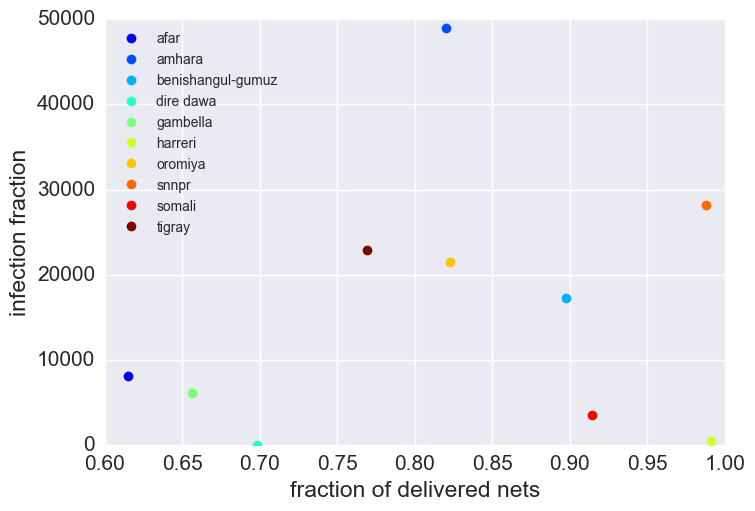

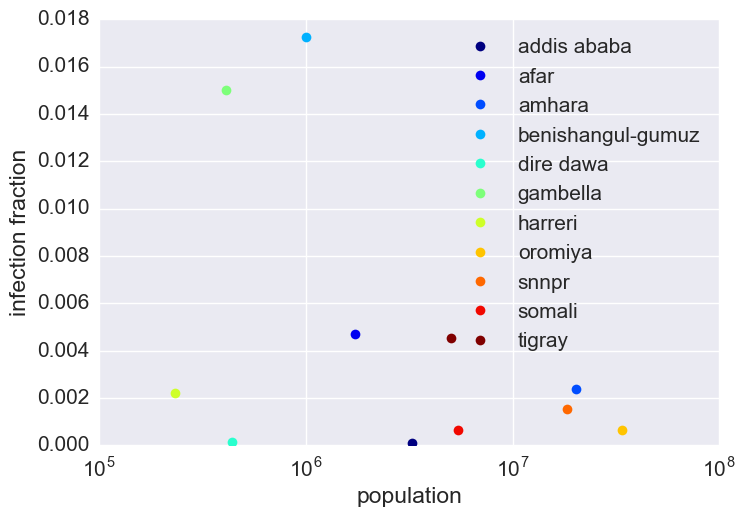

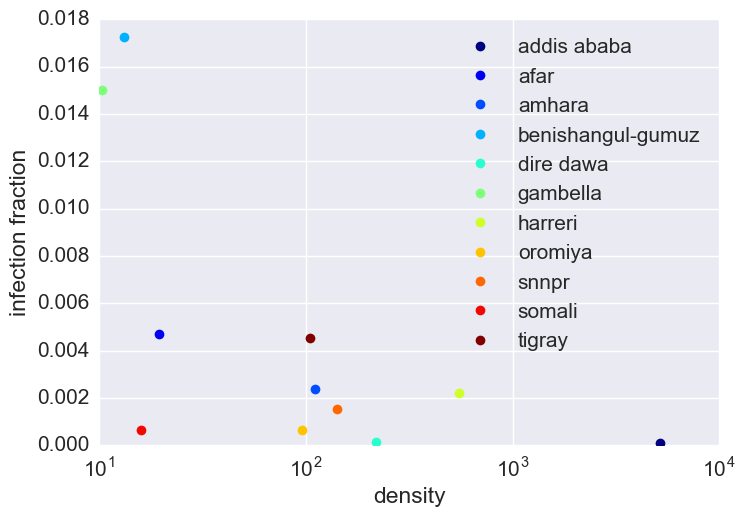

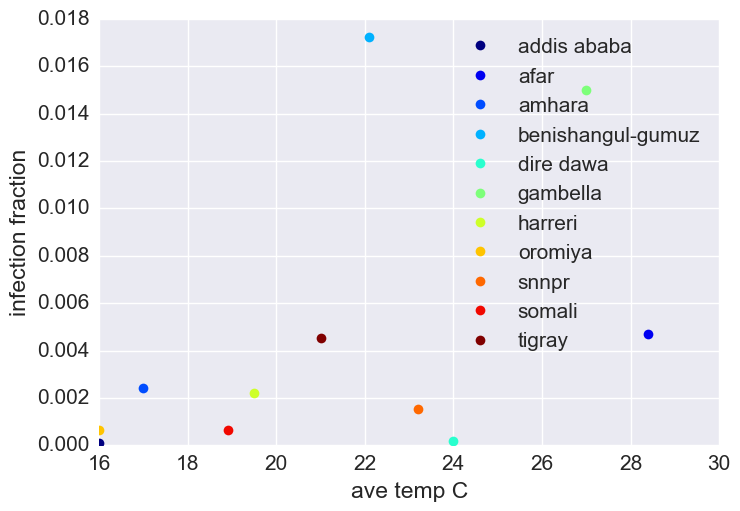

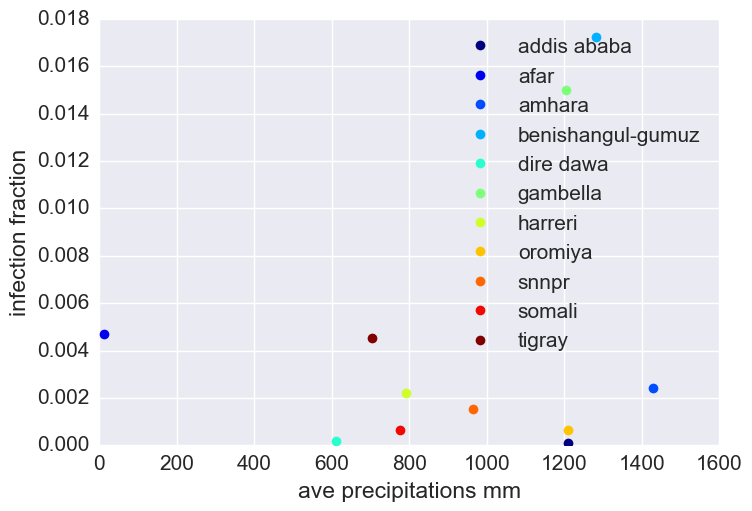

In [827]:
start,stop=0,1
number_of_colors= len(DF_mean)
cm_subsection = linspace(start, stop, number_of_colors) 
colors = [ cm.jet(x) for x in cm_subsection ]

for region,color in zip(DF_mean.index,colors):
    if region != 'addis ababa':
        plt.plot(DF_mean_nets.loc[region]['val'], DF_mean.loc[region]['val'], 'o', color=color, label=region)
legend(fontsize=10, loc='upper left')
#xscale('log')
xlabel('fraction of delivered nets')
ylabel('infection fraction')

figure()

for region,color in zip(DF_mean.index,colors):
    plt.plot(DF_mean.loc[region]['pop'], DF_mean.loc[region]['infection_rate'], 'o', color=color, label=region)
legend()
xscale('log')
xlabel('population')
ylabel('infection fraction')

figure()
for region,color in zip(DF_mean.index,colors):
    plt.plot(DF_mean.loc[region]['density'], DF_mean.loc[region]['infection_rate'], 'o', color=color, label=region)
legend()
xscale('log')
xlabel('density')
ylabel('infection fraction')

figure()
for region,color in zip(DF_mean.index,colors):
    plt.plot(DF_mean.loc[region]['ave_temp'], DF_mean.loc[region]['infection_rate'], 'o', color=color, label=region)
legend()
#xscale('log')
xlabel('ave temp C')
ylabel('infection fraction')

figure()
for region,color in zip(DF_mean.index,colors):
    plt.plot(DF_mean.loc[region]['ave_prec_mm'], DF_mean.loc[region]['infection_rate'], 'o', color=color, label=region)
legend()
#xscale('log')
xlabel('ave precipitations mm')
ylabel('infection fraction')

<h1> Plot indicators </h1>

In [82]:
def pd_proper_dateformat(series):
    '''Given a pandas time series return x, y with the time formatted to plot in matplotlib'''
    return series.index.astype(datetime.datetime), series.values

def frac_err(num, sig_num, den, sig_den):
    return sqrt( (sig_num / den) ** 2 + ((sig_den * num) / (den**2)) ** 2)

In [837]:
def pd_proper_dateformat(series):
    '''Given a pandas time series return x, y with the time formatted to plot in matplotlib'''
    return series.index.astype(datetime.datetime), series.values

def plot_date_indicator(dataframe, indicator, ind2=None, val_name='val'):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['Region', 'E_Date'])[val_name].sum()
    ylab_text = indicator    
    #If not none use indicator 2 as the denominator
    if ind2:
        to_plot /= dataframe.loc[dataframe['Indicator'] == ind2].reset_index().groupby(['Region', 'E_Date'])[val_name].sum()
        ylab_text = '%s per \n %s' % (indicator, ind2)
        
    start,stop=0,1
    number_of_colors= len(to_plot.index.levels[0])
    cm_subsection = linspace(start, stop, number_of_colors) 
    colors = [ cm.jet(x) for x in cm_subsection ]

    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

    for level,color in zip(to_plot.index.levels[0],colors):
        x, y = pd_proper_dateformat(to_plot[level])
        plt.plot_date(x, y, '.-', color=color, markersize=20, label=level,)
    ylabel(ylab_text)
    xlabel('Date')
    legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b\n%Y'))
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
    #yscale('log')
    
    return to_plot

def plot_date_indicator_nation(dataframe, indicator, val_name='val', ind2=None, plt_err=False, plt_mean=False, plt_mean_std=False, x_range=[0,-1]):
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby(['E_Date'])[val_name].sum()
    to_plot = to_plot[x_range[0]:x_range[1]]
    yn = to_plot.values
    sqrtNn = sqrt(yn)
    y_err = sqrtNn
    ylab_text = indicator
    #If not none use indicator 2 as the denominator
    if ind2:
        to_plot_d = dataframe.loc[dataframe['Indicator'] == ind2].reset_index().groupby(['E_Date'])[val_name].sum()
        to_plot /= to_plot_d
        yt = to_plot_d.values
        sqrtNt = sqrt(yt)
        y_err = frac_err(yn, sqrtNn, yt, sqrtNt)
        #use binomial error
        p = to_plot.values
        y_err = sqrt( p*(1-p) / yt )
        ylab_text = '%s per \n %s' % (indicator, ind2)
    
    
    fig=figure()
    fig.set_size_inches(13, 9)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    x, y = pd_proper_dateformat(to_plot)
    y_mean = ones_like(y)*mean(y)
    y_mean_err = std(y) / sqrt(len(y))
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='Nation',)
    
    if plt_err:
        plt.fill_between(x, y-y_err, y+y_err,
            alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
            linewidth=4, linestyle='dashdot', antialiased=True, label=r'1 $\sigma$')
        
    if plt_mean:
        plt.plot_date(x, y_mean, '-', color='k', markersize=20, label='Mean',)
    if plt_mean_std:    
        plt.fill_between(x, y_mean-y_mean_err, y_mean+y_mean_err,
        alpha=0.2, edgecolor='black', facecolor='grey',
        linewidth=4, linestyle='dashdot', antialiased=True)
    
    #x has to be in int to fit the data
    x_fit = to_plot.index.astype(int)
    fit = np.poly1d(np.polyfit(x_fit, y, 1))
    y_lin = fit(x_fit)
    plt.plot_date(x, y_lin,'-', color='r', label='Liner Fit',)
    
    ylabel(ylab_text)
    xlabel('Date')
    legend(loc='upper right', numpoints=1,fontsize=12)
    ax = gca()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b\n%Y'))
    
    return to_plot

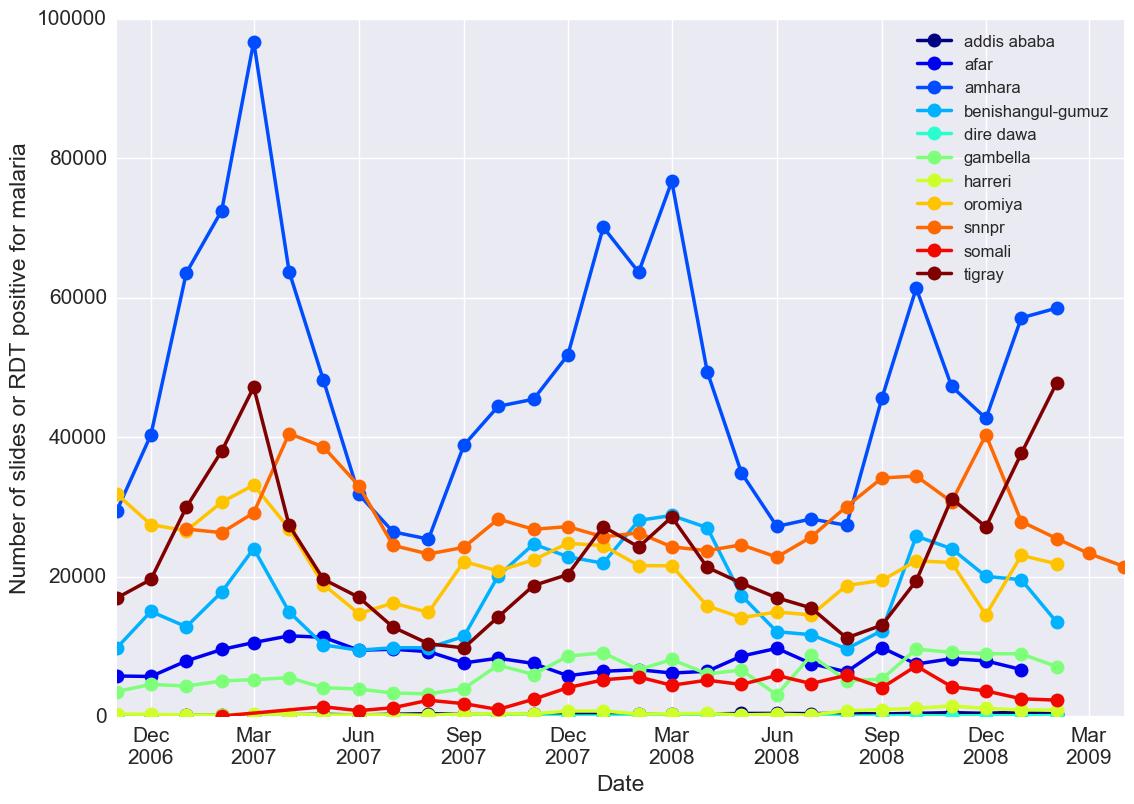

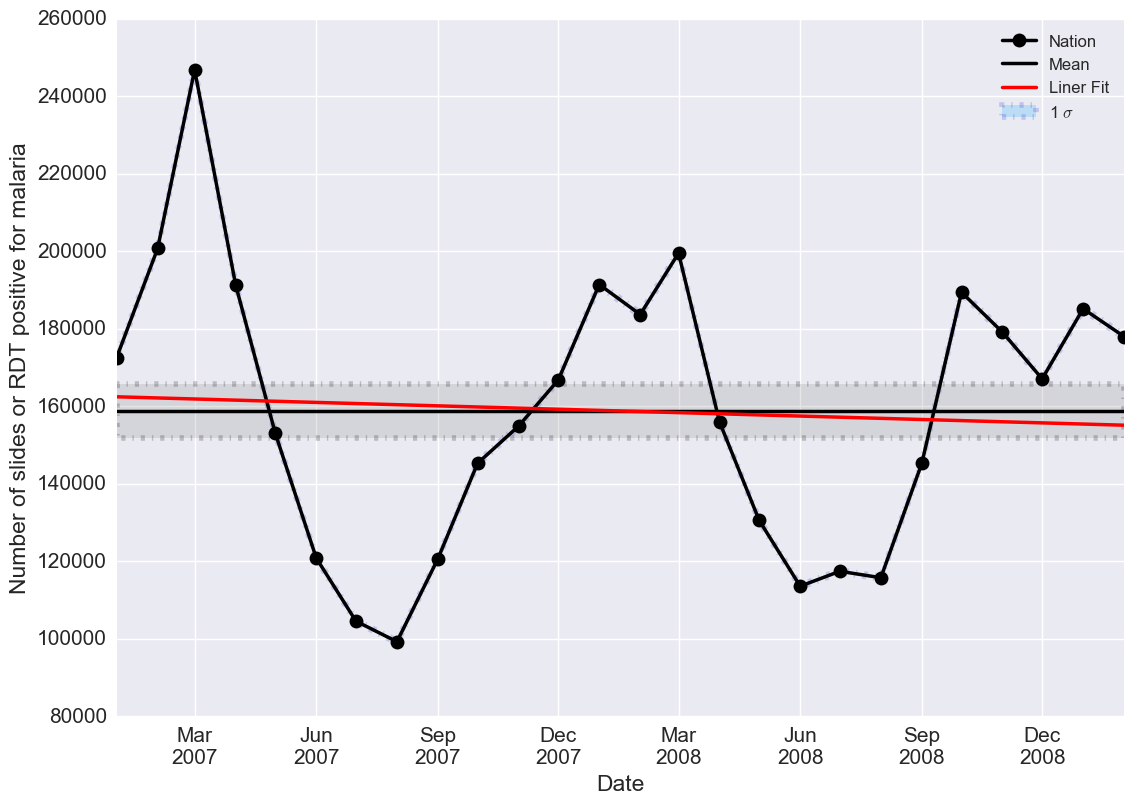

In [838]:
indicator = 'Number of slides or RDT positive for malaria'
series_d = plot_date_indicator(DF_ind, indicator)
series_d = plot_date_indicator_nation(DF_ind, indicator, plt_mean=True, plt_err=True, plt_mean_std=True, x_range=[2,-2])

In [839]:
range_cut = (DF_ind['E_year']>2006) & (DF_ind['E_year']<2009)
DF_pdf = DF_ind.loc[range_cut]
year_sum = DF_pdf.groupby(['E_year']).val.sum()

In [840]:
year_sum

E_year
2007    1.210563e+07
2008    2.194518e+07
Name: val, dtype: float64

In [150]:
DF_pdf.set_index(['E_year', 'E_month']).val.cumsum()

E_year  E_month
2007    1                14.0
        2                28.0
        3                53.0
        4                75.0
        5                88.0
        6               106.0
        7               114.0
        8               137.0
        9               166.0
        10              197.0
        11              211.0
        12              286.0
2008    1               364.0
        2               387.0
        3               405.0
        4               431.0
        5               450.0
        6               465.0
        7               472.0
        8               518.0
        9               586.0
        10              675.0
        11              805.0
        12              872.0
2007    1               883.0
                      ...    
2008    12         19733391.0
2007    1          19737730.0
        2          19742802.0
        3          19748063.0
        4          19753601.0
        5          19757717.0
        6          19761

In [146]:
DF_pdf.reset_index().groupby(['E_year', 'E_month']).cumsum()

,density,infection_rate,pop,val,year_pdf
0,549.03,0.000060,232000,14.0,1.454156e-06
1,549.03,0.000060,232000,14.0,1.454156e-06
2,549.03,0.000108,232000,25.0,2.596707e-06
3,549.03,0.000095,232000,22.0,2.285102e-06
4,549.03,0.000056,232000,13.0,1.350288e-06
5,549.03,0.000078,232000,18.0,1.869629e-06
6,549.03,0.000034,232000,8.0,8.309463e-07
7,549.03,0.000099,232000,23.0,2.388971e-06
8,549.03,0.000125,232000,29.0,3.012180e-06
9,549.03,0.000134,232000,31.0,3.219917e-06


<h3> number of malaria cases are slighly trending up </h3>

In [134]:
DF_pdf['year_pdf'] = DF_pdf['val']/[year_sum[year] for year in DF_pdf['E_year']]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [135]:
DF_pdf['year_pdf']

Real_Date
2014-09-11    1.454156e-06
2014-10-11    1.454156e-06
2014-11-10    2.596707e-06
2014-12-10    2.285102e-06
2015-01-09    1.350288e-06
2015-02-08    1.869629e-06
2015-03-10    8.309463e-07
2015-04-09    2.388971e-06
2015-05-09    3.012180e-06
2015-06-08    3.219917e-06
2015-07-08    1.454156e-06
2015-08-07    7.790121e-06
2015-09-12    7.607283e-06
2015-10-12    2.243173e-06
2015-11-11    1.755527e-06
2015-12-11    2.535761e-06
2016-01-10    1.853056e-06
2016-02-09    1.462939e-06
2016-03-10    6.827049e-07
2016-04-09    4.486346e-06
2016-05-09    6.631990e-06
2016-06-08    8.680105e-06
2016-07-08    1.267881e-05
2016-08-07    6.534461e-06
2014-09-11    1.142551e-06
                  ...     
2016-08-07    1.136021e-03
2014-09-11    4.506845e-04
2014-10-11    5.268199e-04
2014-11-10    5.464510e-04
2014-12-10    5.752226e-04
2015-01-09    4.275219e-04
2015-02-08    4.062289e-04
2015-03-10    3.470239e-04
2015-04-09    3.354946e-04
2015-05-09    4.141228e-04
2015-06-08    7.63

(1, 13)

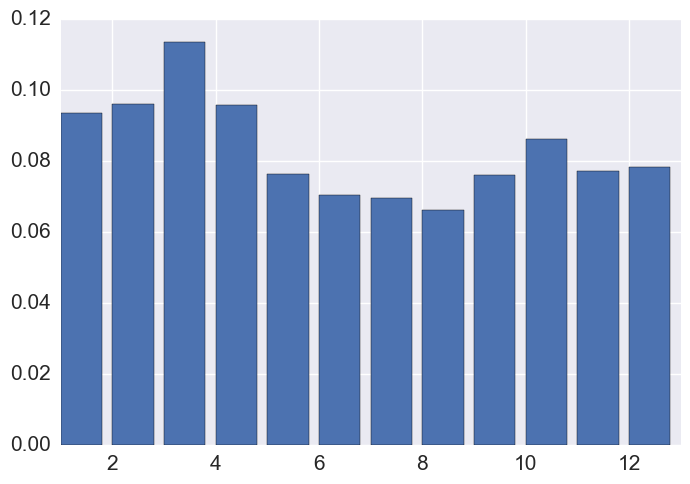

In [113]:
monthly = DF_ind.groupby('E_month').val.mean()
plt.bar(monthly.index, monthly.values/ sum(monthly.values))
xlim(1,13)

<h1> Load in weather data </h1>

In [245]:
DF_weather = pd.read_excel('/Users/attiladobi/Documents/Ethiopia_weather.xlsx', header=1).dropna(how='all').set_index(['city','Field'])

(array([ 32.,   1.,   0.,   0.,   2.,   2.,   1.,   0.,   3.,   1.]),
 array([    8. ,   150.2,   292.4,   434.6,   576.8,   719. ,   861.2,
         1003.4,  1145.6,  1287.8,  1430. ]),
 <a list of 10 Patch objects>)

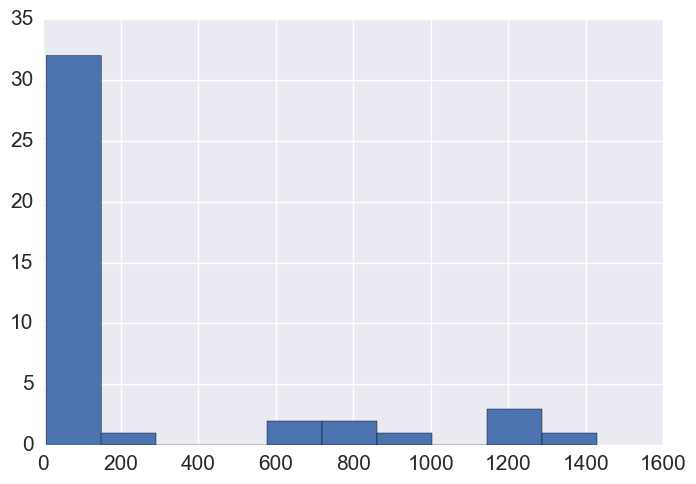

In [192]:
plt.hist(DF_weather['ANNUAL'].dropna().values)

<h3> Temperature distribution </h3>

15.0 32.0


(array([  5.,   7.,  12.,   4.,   5.,   8.,  15.,   9.,   9.,   2.,   9.,
         11.,   5.,   6.,   1.,   4.,   3.,   2.,   0.,   3.]),
 array([ 15.  ,  15.85,  16.7 ,  17.55,  18.4 ,  19.25,  20.1 ,  20.95,
         21.8 ,  22.65,  23.5 ,  24.35,  25.2 ,  26.05,  26.9 ,  27.75,
         28.6 ,  29.45,  30.3 ,  31.15,  32.  ]),
 <a list of 20 Patch objects>)

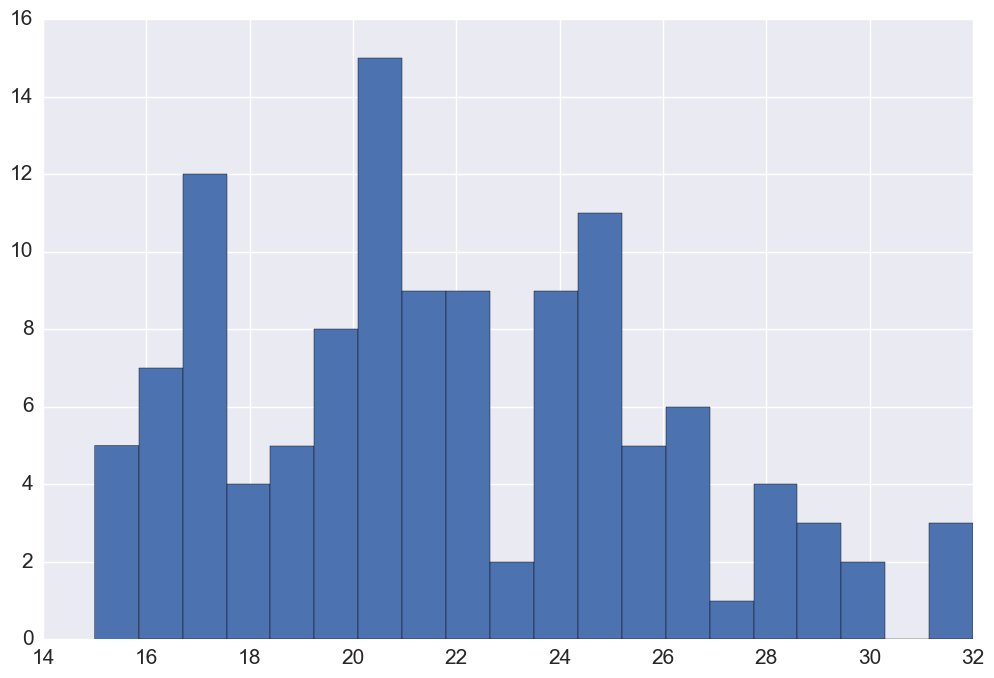

In [307]:
AA = DF_weather.drop('ANNUAL',1).replace(nan,0).reset_index()
AA = AA.loc[AA['Field'] == 'temp'].set_index('city').drop('Field',1)
all_data = [val for sub in AA.values for val in sub]
print min(all_data) , max(all_data)
plt.hist(all_data,20)

<h3> Precipitation distribution </h3>

0.0 434.0


(array([ 30.,  14.,  13.,  10.,   7.,   6.,   4.,   9.,   6.,   2.,   2.,
          2.,   2.,   2.,   3.,   2.,   2.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([   0.        ,   14.46666667,   28.93333333,   43.4       ,
          57.86666667,   72.33333333,   86.8       ,  101.26666667,
         115.73333333,  130.2       ,  144.66666667,  159.13333333,
         173.6       ,  188.06666667,  202.53333333,  217.        ,
         231.46666667,  245.93333333,  260.4       ,  274.86666667,
         289.33333333,  303.8       ,  318.26666667,  332.73333333,
         347.2       ,  361.66666667,  376.13333333,  390.6       ,
         405.06666667,  419.53333333,  434.        ]),
 <a list of 30 Patch objects>)

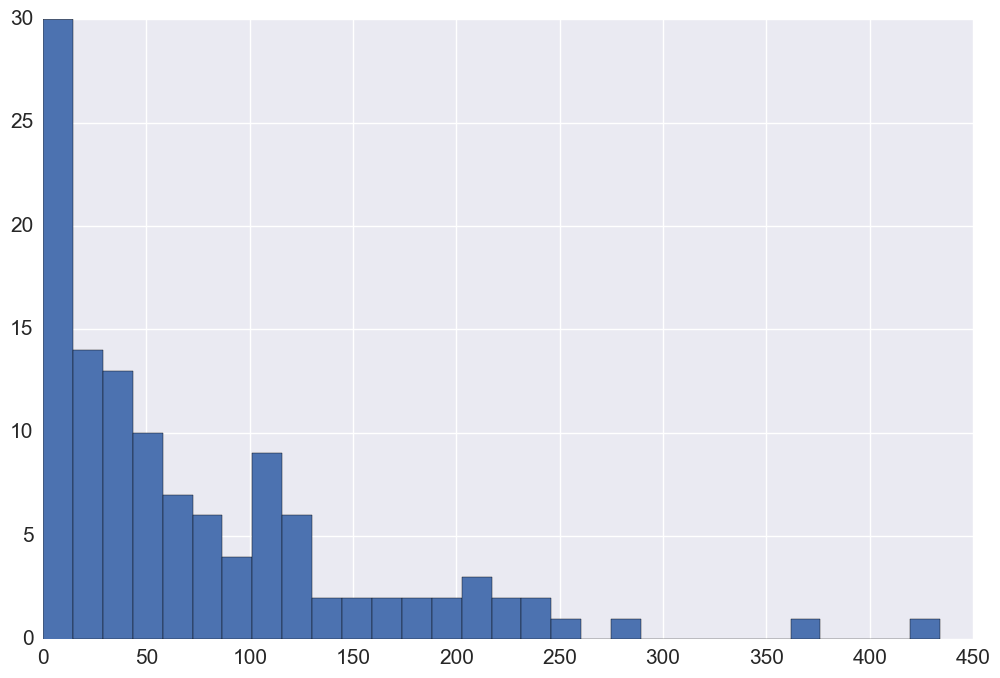

In [309]:
AA = DF_weather.drop('ANNUAL',1).replace(nan,0).reset_index()
AA = AA.loc[AA['Field'] == 'prec_mm'].set_index('city').drop('Field',1)
all_data = [val for sub in AA.values for val in sub]
print min(all_data) , max(all_data)
plt.hist(all_data,30)

<h1> Add weather data and catagorize them</h1>

In [922]:
def temp_map(temp):
    if temp < 20:
        return 0
    elif (temp >= 20) & (temp < 30):
        return 1
    elif (temp >= 25) & (temp < 30):
        return 2
    else:
        return 3
    
def prec_map(precip):
    if precip < 20:
        return 0
    elif (precip >= 20) & (precip < 50):
        return 1
    elif (precip >= 55) & (precip < 100):
        return 2
    else:
        return 3

In [923]:
month_map = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12 }
inv_month_map = {v: k for k, v in month_map.iteritems()}

In [924]:
DF_ind['temp'] = [DF_weather.loc[capital,'temp'][inv_month_map[month]] for capital,month in zip(DF_ind['capital'],DF_ind['month'])]
DF_ind['prec_mm'] = [DF_weather.loc[capital,'prec_mm'][inv_month_map[month]] for capital,month in zip(DF_ind['capital'],DF_ind['month'])]

In [925]:
DF_ind['temp_cat'] = [temp_map(temp) for temp in DF_ind['temp']]
DF_ind['prec_cat'] = [prec_map(prec) for prec in DF_ind['prec_mm']]

<h1> For prediction only use one indicator "number testing positive for malaria" </h1>

In [926]:
DF_shift = DF_ind

<h1> add leading indicators </h1>

In [927]:
DF_shift['val_shift_1'] = DF_ind.shift(1)['val']
DF_shift['temp_cat_shift_1'] = DF_ind.shift(1)['temp_cat']
DF_shift['prec_cat_shift_1'] = DF_ind.shift(1)['prec_cat']
DF_shift['Region_shift_1'] = DF_ind.shift(1)['Region']
DF_shift['Ind_shift_1'] = DF_ind.shift(1)['Indicator']

DF_shift['val_shift_2'] = DF_ind.shift(2)['val']
DF_shift['temp_cat_shift_2'] = DF_ind.shift(2)['temp_cat']
DF_shift['prec_cat_shift_2'] = DF_ind.shift(2)['prec_cat']
DF_shift['Region_shift_2'] = DF_ind.shift(2)['Region']
DF_shift['Ind_shift_2'] = DF_ind.shift(2)['Indicator']

<h3> clean up nan and region missmatch. Require the region and the indicator to be the same </h3>

In [928]:
DF_shift = DF_ind.loc[(DF_ind['Region'] == DF_ind['Region_shift_1']) &\
                      (DF_ind['Indicator'] == DF_ind['Ind_shift_1']) &\
                      (DF_ind['Region'] == DF_ind['Region_shift_2']) &\
                      (DF_ind['Indicator'] == DF_ind['Ind_shift_2']) ]

In [929]:
DF_ind.columns

Index([u'Indicator_id', u'val', u'Region', u'Indicator', u'E_Date', u'E_year',
       u'E_month', u'month', u'year', u'capital', u'pop', u'density',
       u'ave_temp', u'ave_prec_mm', u'elevation_m', u'infection_rate',
       u'net_frac', u'temp', u'prec_mm', u'temp_cat', u'prec_cat',
       u'val_shift_1', u'temp_cat_shift_1', u'prec_cat_shift_1',
       u'Region_shift_1', u'Ind_shift_1', u'val_shift_2', u'temp_cat_shift_2',
       u'prec_cat_shift_2', u'Region_shift_2', u'Ind_shift_2'],
      dtype='object')

In [930]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor()

In [932]:
y = DF_shift.infection_rate.values

x = DF_shift[['pop','density','month', 'net_frac', 'elevation_m', 'temp_cat','prec_cat', 'val_shift_1', 'temp_cat_shift_1', 'prec_cat_shift_1',\
             'val_shift_2', 'temp_cat_shift_2', 'prec_cat_shift_2']].values

RF.fit(x,y)

print RF.feature_importances_

prediction = [RF.predict(val) for val in x]

DF_shift['prediction'] = [val[0] for val in prediction]

[  2.14094361e-01   2.60474013e-01   9.91152927e-03   2.13306469e-02
   1.13601995e-02   1.10717112e-04   2.52310808e-03   3.74684243e-01
   6.08629361e-04   1.38550876e-02   8.71811046e-02   4.70007830e-04
   3.39635329e-03]


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

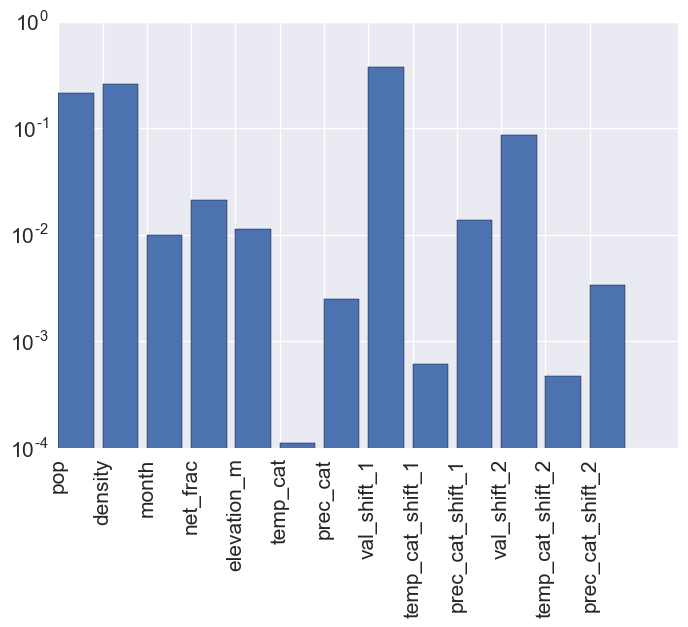

In [933]:
features = ['pop','density','month', 'net_frac', 'elevation_m', 'temp_cat', 'prec_cat', 'val_shift_1', 'temp_cat_shift_1', 'prec_cat_shift_1',\
             'val_shift_2', 'temp_cat_shift_2', 'prec_cat_shift_2']
x = range(len(RF.feature_importances_))
plt.bar(x, RF.feature_importances_)
xticks(x, features, rotation = 'vertical')
yscale('log')

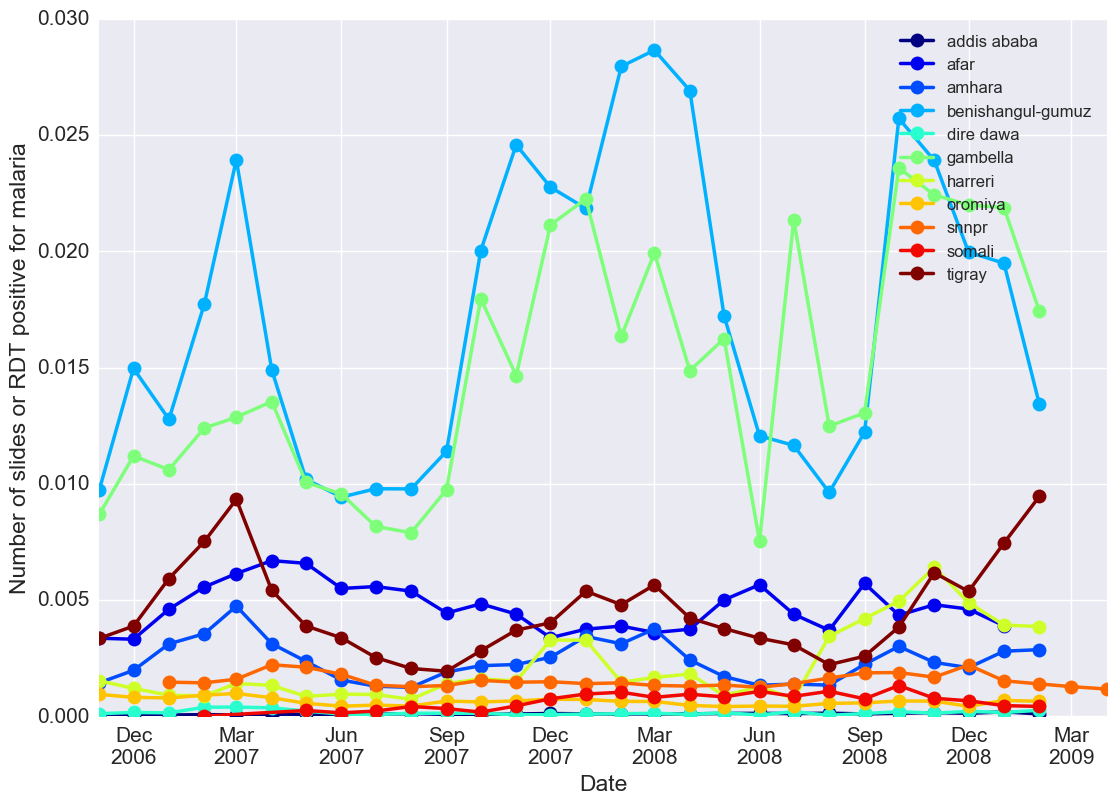

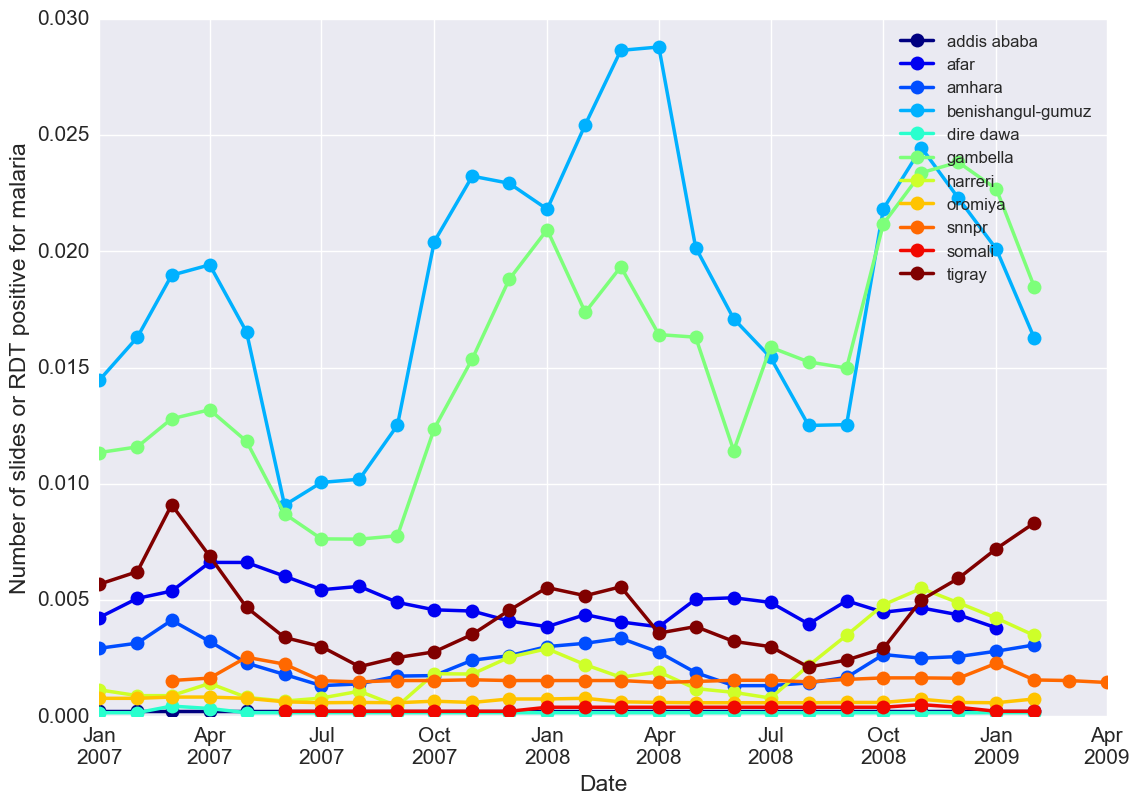

In [934]:
indicator = 'Number of slides or RDT positive for malaria'
series_d = plot_date_indicator(DF_ind, indicator, val_name='infection_rate')
series_d = plot_date_indicator(DF_shift, indicator, val_name='prediction')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


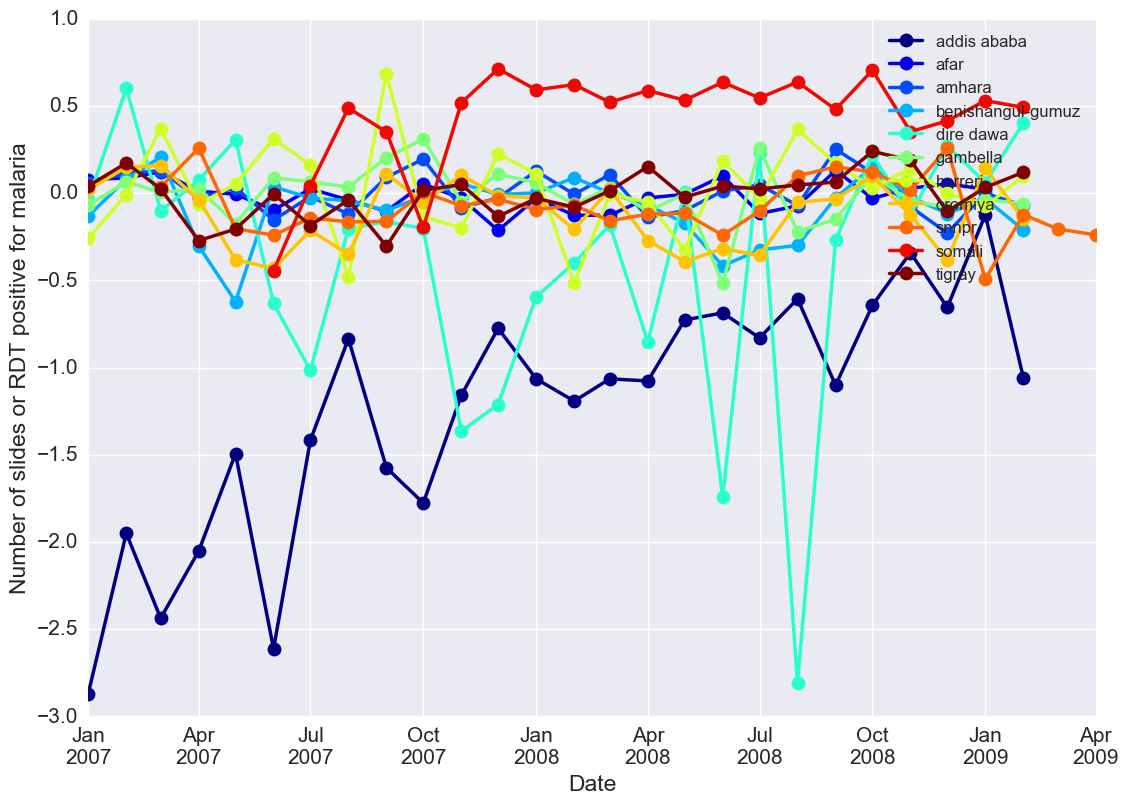

In [935]:
DF_shift['diff'] = DF_shift['infection_rate']-DF_shift['prediction']
DF_shift['norm_diff'] = (DF_shift['infection_rate']-DF_shift['prediction']) / DF_shift['infection_rate']
series_d = plot_date_indicator(DF_shift, indicator, val_name='norm_diff')

In [721]:
sqrt(mean((DF_shift['infection_rate']-DF_shift['prediction'])**2))

0.00062951216832694032

<h1> predicting the values </h1>

In [901]:
y = DF_shift.val.values

x = DF_shift[['pop','density','month', 'net_frac', 'elevation_m', 'temp_cat','prec_cat', 'val_shift_1', 'temp_cat_shift_1', 'prec_cat_shift_1',\
             ]].values
# 'val_shift_2', 'temp_cat_shift_2', 'prec_cat_shift_2'

RF.fit(x,y)

print RF.feature_importances_

prediction = [RF.predict(val) for val in x]

DF_shift['prediction'] = [val[0] for val in prediction]


[  1.58575960e-03   8.20741870e-04   6.81457178e-03   1.69108398e-03
   1.78891611e-03   3.23365383e-04   2.50690860e-03   9.81055187e-01
   4.87194230e-04   2.92627169e-03]


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/lo

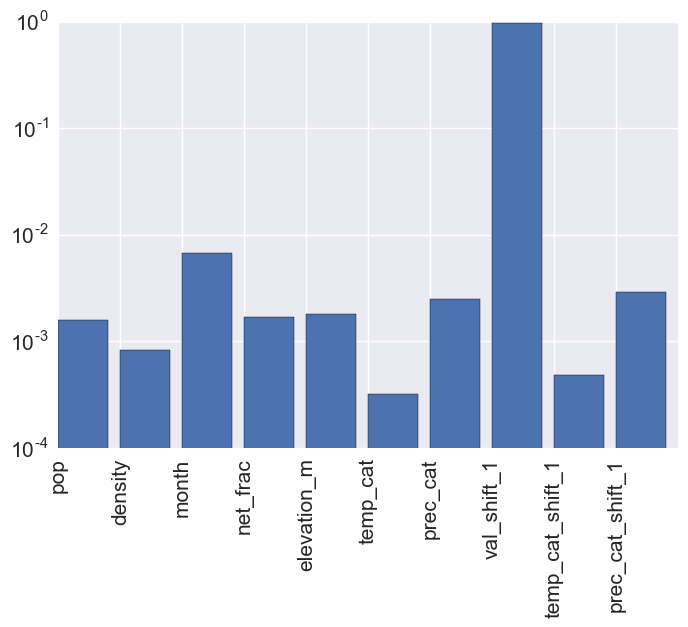

In [902]:
features = ['pop','density','month', 'net_frac', 'elevation_m', 'temp_cat','prec_cat', 'val_shift_1', 'temp_cat_shift_1', 'prec_cat_shift_1']
             #'val_shift_2', 'temp_cat_shift_2', 'prec_cat_shift_2']
x = range(len(RF.feature_importances_))
plt.bar(x, RF.feature_importances_)
xticks(x, features, rotation = 'vertical')
yscale('log')

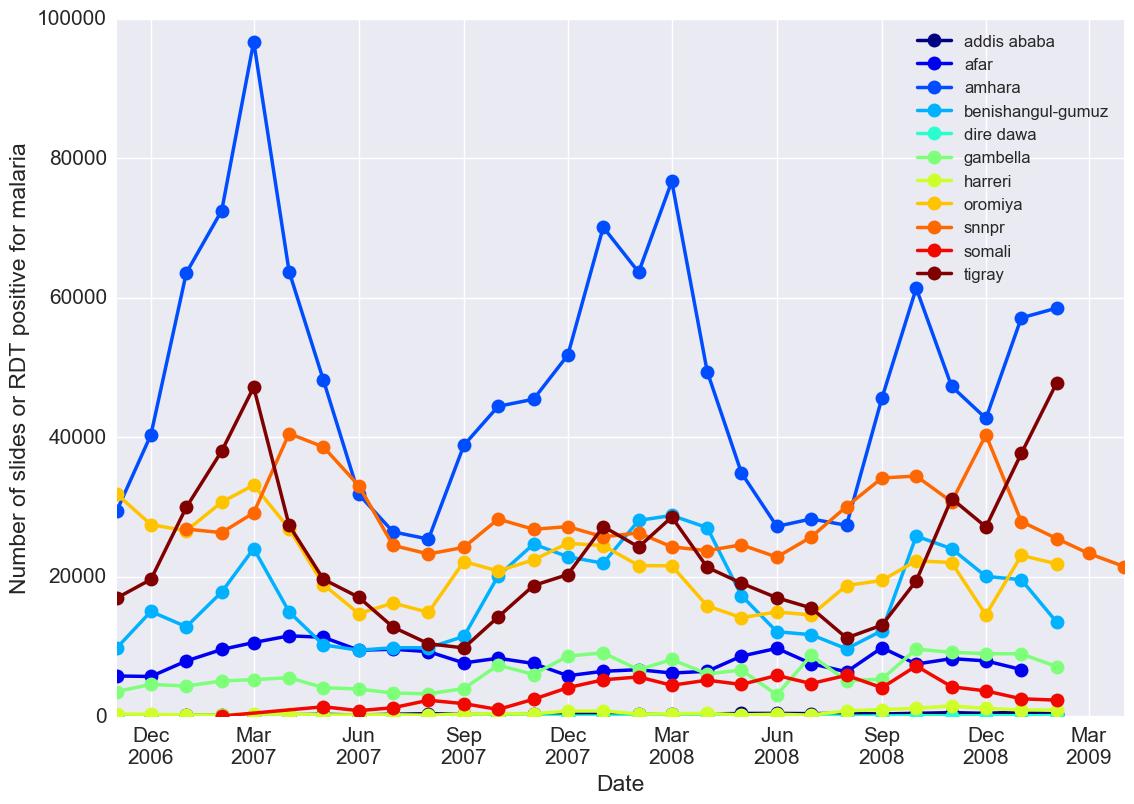

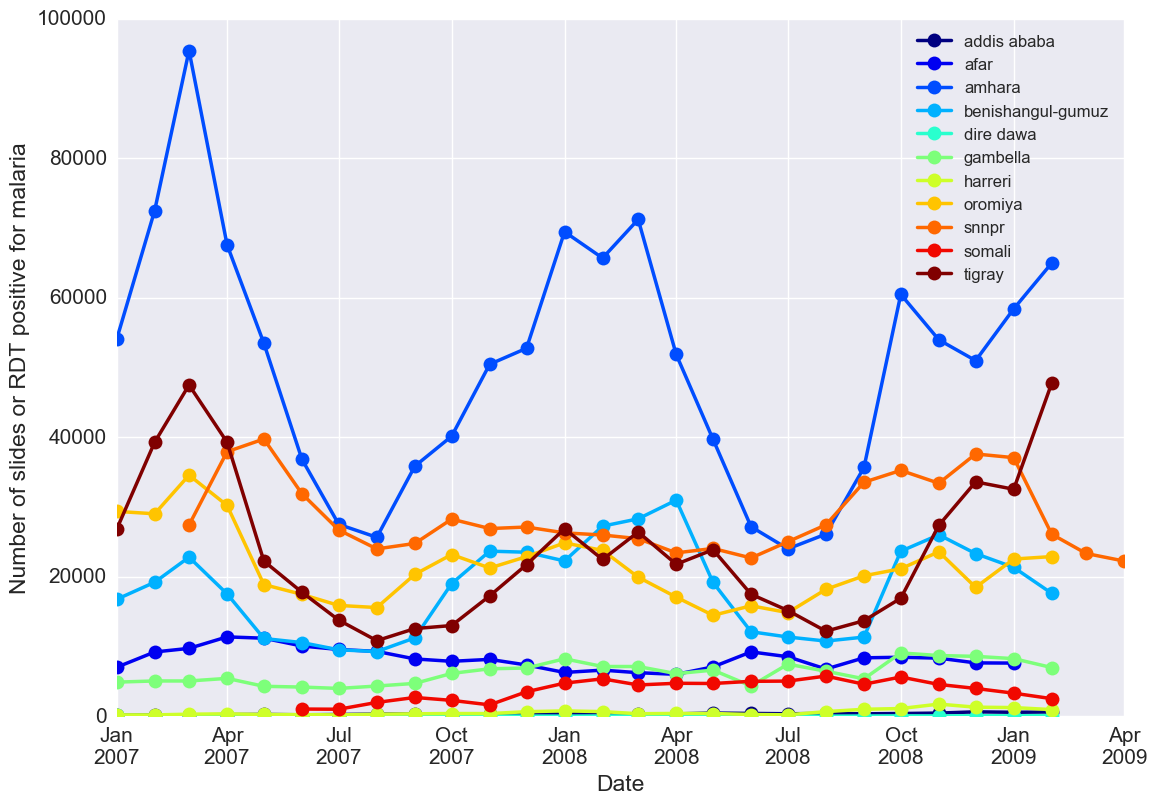

In [903]:
indicator = 'Number of slides or RDT positive for malaria'
series_d = plot_date_indicator(DF_ind, indicator, val_name='val')
series_d = plot_date_indicator(DF_shift, indicator, val_name='prediction')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

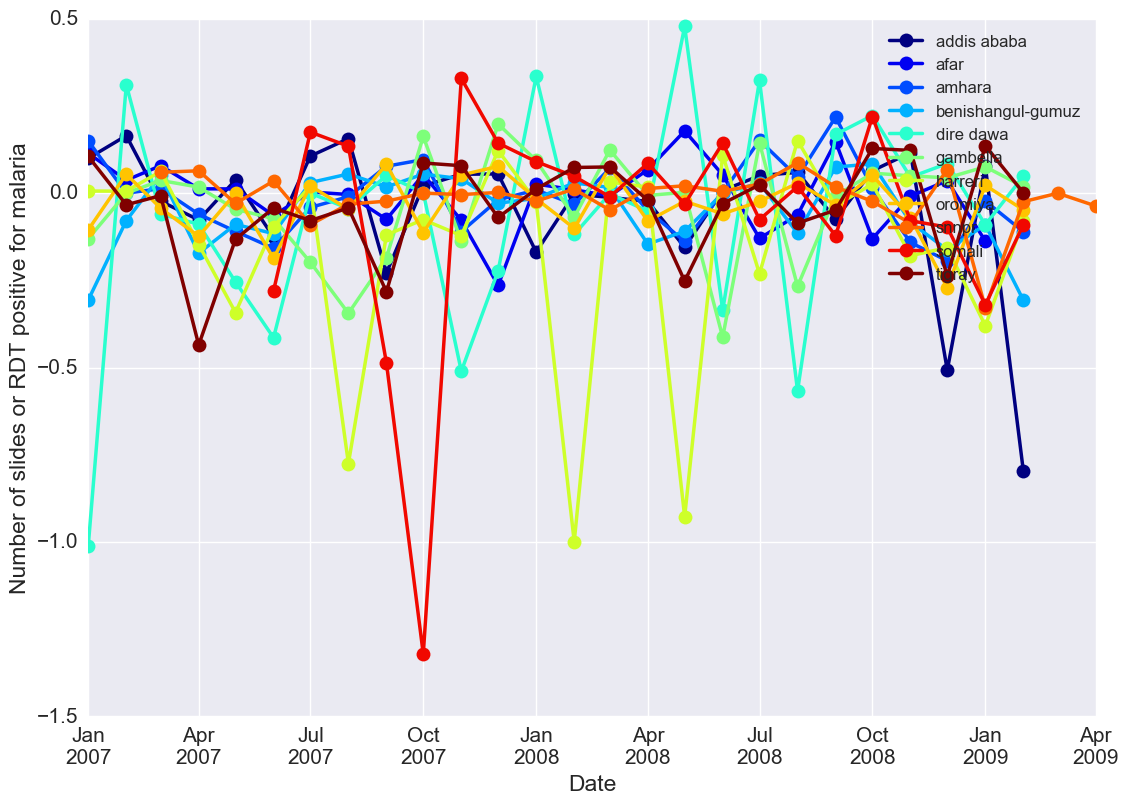

In [904]:
DF_shift['diff'] = DF_shift['val']-DF_shift['prediction']
DF_shift['norm_diff'] = (DF_shift['val']-DF_shift['prediction']) / DF_shift['val']
DF_shift['mse'] = (DF_shift['val']-DF_shift['prediction']) ** 2
series_d = plot_date_indicator(DF_shift, indicator, val_name='norm_diff')

In [905]:
sqrt(mean((DF_shift['val']-DF_shift['prediction'])**2))

1797.309331590619

In [906]:
sqrt(DF_shift.groupby('Region').mse.mean())/DF_shift.groupby('Region').mse.mean()*100

Region
addis ababa          1.474068
afar                 0.196650
amhara               0.024141
benishangul-gumuz    0.075510
dire dawa            1.162140
gambella             0.185967
harreri              1.097499
oromiya              0.048917
snnpr                0.041457
somali               0.213632
tigray               0.045681
Name: mse, dtype: float64

<h1> Extrapolate for 1 year </h1>

In [762]:
series_d

Region       E_Date    
addis ababa  2007-01-01    0.056284
             2007-02-01    0.211667
             2007-03-01   -0.025890
             2007-04-01   -0.013362
             2007-05-01    0.023239
             2007-06-01   -0.096939
             2007-07-01   -0.078498
             2007-08-01    0.139292
             2007-09-01   -0.264000
             2007-10-01   -0.047451
             2007-11-01    0.039024
             2007-12-01    0.048622
             2008-01-01   -0.307872
             2008-02-01    0.120124
             2008-03-01    0.014189
             2008-04-01    0.015249
             2008-05-01    0.082683
             2008-06-01   -0.221905
             2008-07-01   -0.092765
             2008-08-01    0.174150
             2008-09-01   -0.054599
             2008-10-01    0.081206
             2008-11-01    0.078788
             2008-12-01   -0.138785
             2009-01-01    0.078571
                             ...   
tigray       2007-02-01    0.000000
    